In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Intro
Autoencoders are trained by encoding an image into a latent representation then reconstructing the image. They use and MSE loss to compare the reconstructed and original images. These have practical applications, such as image denoising (training inputs are noisy images and targets are cleaned up images), anomaly detection (by setting a threshold error, above which you consider input images to have anomalies), and image coloring.

Note strictly speaking autoencoders don't need to use images. They just have to encode then decode.

# Load Data

In [3]:
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

(<matplotlib.image.AxesImage at 0x17f06bc7e50>, (60000, 28, 28))

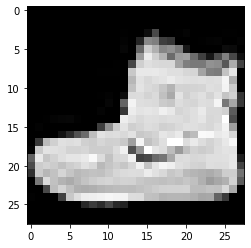

In [25]:
plt.imshow(x_train[0]), x_train.shape

# Basic Autoencoder

In [26]:
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential(
            [layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')]
        )

        self.decoder = tf.keras.Sequential(
            [layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28 ,28))]
        )
    # Forward pass
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [52]:
autoencoder.build((None, 28, 28))
autoencoder.summary()

Model: "autoencoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64)                50240     
                                                                 
 sequential_5 (Sequential)   (None, 28, 28)            50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [27]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0238 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

Model: "autoencoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64)                50240     
                                                                 
 sequential_5 (Sequential)   (None, 28, 28)            50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


# Visualization

In [28]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

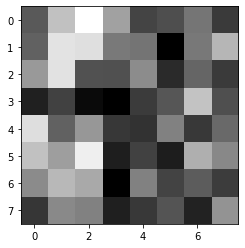

In [31]:
encoded_pics = encoded_imgs.reshape((10000, 8,8))
plt.imshow(encoded_pics[0])

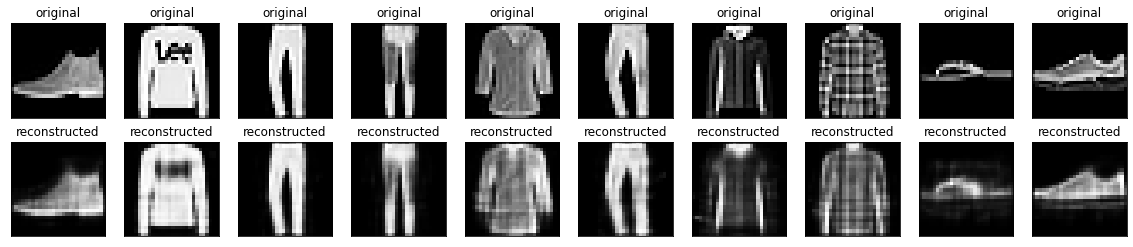

In [30]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Autoencoder

In [33]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

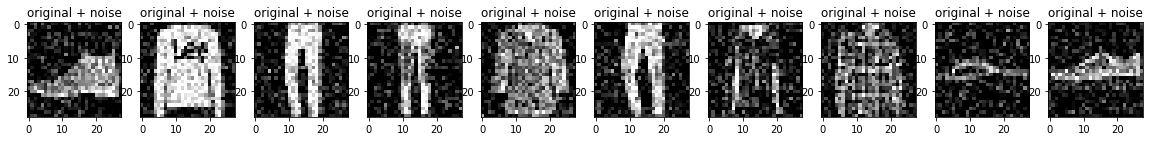

In [34]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [41]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28,28,1)),
            layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

denoise = Denoise()
denoise.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [55]:
32*28*28*1, 32*7*7*32

(25088, 50176)

In [53]:
denoise.build((None, 28, 28))
denoise.summary()

Model: "denoise_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 7, 7, 16)          2480      
                                                                 
 sequential_11 (Sequential)  (None, 28, 28, 1)         2473      
                                                                 
Total params: 4,953
Trainable params: 4,953
Non-trainable params: 0
_________________________________________________________________


In [42]:
denoise.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0149 - val_loss: 0.0085
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.006

In [44]:
encoded_imgs = denoise.encoder(x_test_noisy).numpy()
decoded_imgs = denoise.decoder(encoded_imgs).numpy()

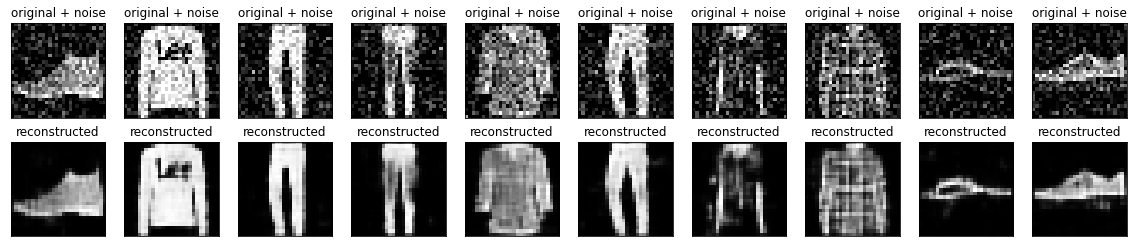

In [45]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()